In [26]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.special import inv_boxcox
from src.clean_and_merge import downcast_numeric

In [2]:
df = pd.read_csv('data/processed_data/merged_data.csv')

In [5]:
df.describe()

,year_sold,floor_area_sqm,remaining_lease,storey,resale_price
count,916482.000000,916482.000000,916482.000000,916482.000000,9.164820e+05
mean,2006.016671,95.717467,81.175948,7.680646,3.263779e+05
std,9.178919,25.838126,10.632995,4.810727,1.266477e+05
min,1990.000000,28.000000,41.000000,2.000000,1.632653e+04
25%,1999.000000,73.000000,74.000000,5.000000,2.312925e+05
50%,2005.000000,93.000000,83.000000,8.000000,3.070761e+05
75%,2013.000000,113.000000,90.000000,11.000000,3.886926e+05
max,2024.000000,307.000000,101.000000,50.000000,1.198675e+06


In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916482 entries, 0 to 916481
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   year_sold        916482 non-null  int64  
 1   floor_area_sqm   916482 non-null  float64
 2   remaining_lease  916482 non-null  int64  
 3   storey           916482 non-null  float64
 4   flat_type        916482 non-null  object 
 5   town             916482 non-null  object 
 6   block            916482 non-null  object 
 7   street_name      916482 non-null  object 
 8   flat_model       916482 non-null  object 
 9   resale_price     916482 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 285.7 MB


In [4]:
mem = df.memory_usage(deep=True) / 1024**2
mem.apply(lambda x: '{:.2f} MB'.format(x))

Index               0.00 MB
year_sold           6.99 MB
floor_area_sqm      6.99 MB
remaining_lease     6.99 MB
storey              6.99 MB
flat_type          48.27 MB
town               50.72 MB
block              45.39 MB
street_name        55.07 MB
flat_model         51.25 MB
resale_price        6.99 MB
dtype: object

In [20]:
# convert some values to category
df['flat_type'] = df['flat_type'].astype('category')
df['flat_model'] = df['flat_model'].astype('category')
df['towm'] = df['town'].astype('category')

# downcast the remaining numerical values
df = downcast_numeric(df)

In [21]:
mem = df.memory_usage(deep=True) / 1024**2
mem.apply(lambda x: '{:.2f} MB'.format(x))

Index                   0.00 MB
year_sold               1.75 MB
floor_area_sqm          3.50 MB
remaining_lease         0.87 MB
storey                  3.50 MB
flat_type               0.87 MB
town                   50.72 MB
block                  45.39 MB
street_name            55.07 MB
flat_model              0.88 MB
resale_price            6.99 MB
log_resale_price        3.50 MB
boxcox_resale_price     3.50 MB
towm                    0.88 MB
dtype: object

# EDA

## resale_price

Skew: 0.9872924998796199
Kurtosis: 1.1918729009726645
Skew: -0.19083598327463674
Kurtosis: 0.5433007498791071
Skew: 0.005227103972802157
Kurtosis: 0.23650678307193695


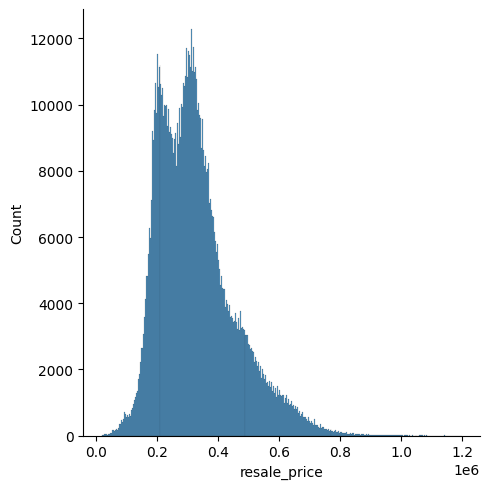

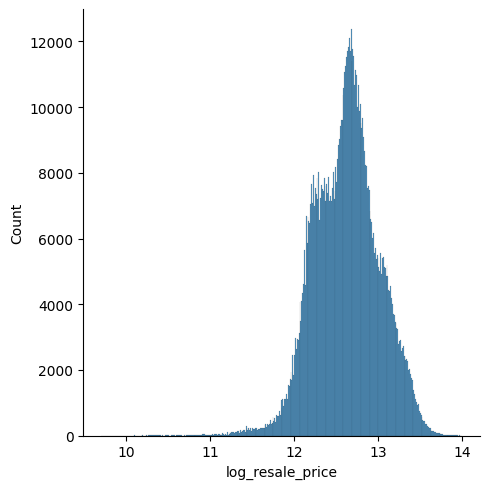

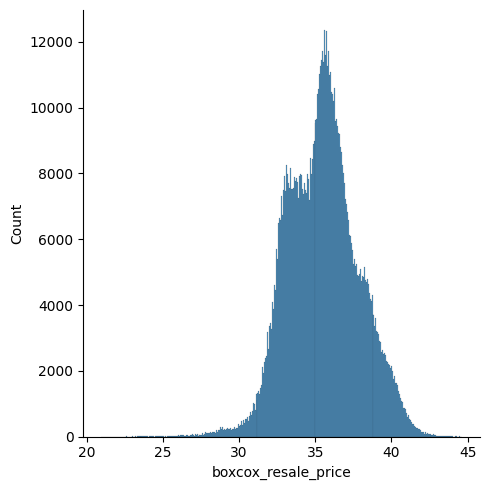

In [6]:
# Check for normal distribution of target variable
sns.displot(df['resale_price'])

# Check for skewness and kurtosis
# Skewness measures the degree to which your data is lopsided compared to a normal distribution (which is symmetrical).
# Positive Skew: Your data has a longer tail on the right side. This means there are more frequent lower values and less frequent, but potentially extreme, high values.
# Negative Skew: Your data has a longer tail on the left side. This indicates more frequent higher values and less frequent, but potentially extreme, low values.
# Symmetrical: Your data is normally distributed. Value of 0
print(f"Skew: {df['resale_price'].skew()}")
# Kurtosis measures how 'peaked' the distribution is and how heavy or light the tails are. This is done in comparison to a normal distribution.
# Leptokurtic: A distribution with a higher peak and heavier tails than a normal distribution. This implies more values clustered around the mean and more potential for outliers. >3
# Platykurtic: A distribution with a lower peak and lighter tails than a normal distribution. This indicates a wider spread of data with fewer outliers. <3
# Mesokurtic: A distribution similar in shape to a normal distribution. Value of 3
print(f"Kurtosis: {df['resale_price'].kurt()}")

# Log transformation
df['log_resale_price'] = np.log(df['resale_price'])
sns.displot(df['log_resale_price'])

# Check for skewness and kurtosis
print(f"Skew: {df['log_resale_price'].skew()}")
print(f"Kurtosis: {df['log_resale_price'].kurt()}")

# Box-Cox transformation
df['boxcox_resale_price'], lmbda = boxcox(df['resale_price'])
sns.displot(df['boxcox_resale_price'])

# Check for skewness and kurtosis
print(f"Skew: {df['boxcox_resale_price'].skew()}")
print(f"Kurtosis: {df['boxcox_resale_price'].kurt()}")


<Axes: xlabel='resale_price', ylabel='Count'>

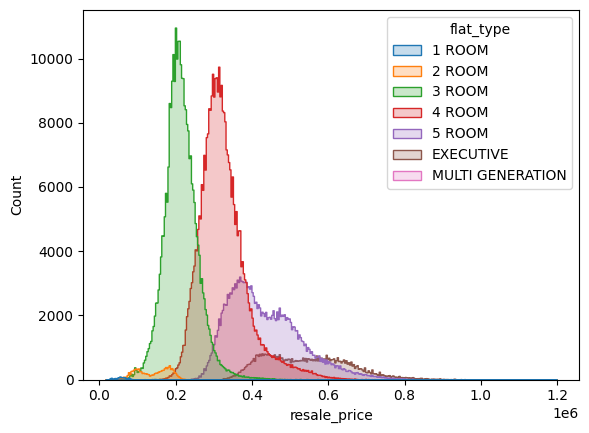

In [16]:
### Investigate the 2 peaks. Plot a ridge plot of resale price against flat_type
sns.histplot(df, x='resale_price', hue='flat_type', element='step', fill=True, common_norm=False)

In [65]:
# for each flat type, investigate the correlation heatmap
flat_types = df['flat_type'].unique()
for flat_type in flat_types:
    flat_type_df = df[df['flat_type'] == flat_type]
    corr = flat_type_df.select_dtypes(include=['number']).corr()
    sns.heatmap(corr, annot=True)
    plt.title(f'Correlation Heatmap for {flat_type}')
    plt.show()
    print(flat_type_df['flat_model'].value_counts())
    print(flat_type_df['town'].value_counts())

KeyboardInterrupt: 

## remaining_lease

In [10]:
# Compare the data for those with remaining lease 94 years and below and those above 94 years
df_94 = df[df['remaining_lease'] <= 94]
df_95 = df[df['remaining_lease'] > 94]

Skew: 1.0282943070782202
Kurtosis: 1.3165538516471287


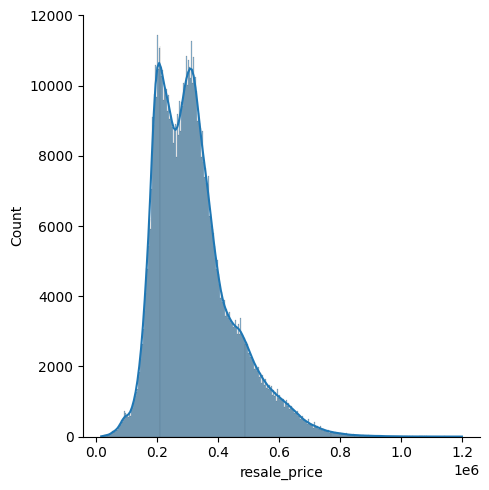

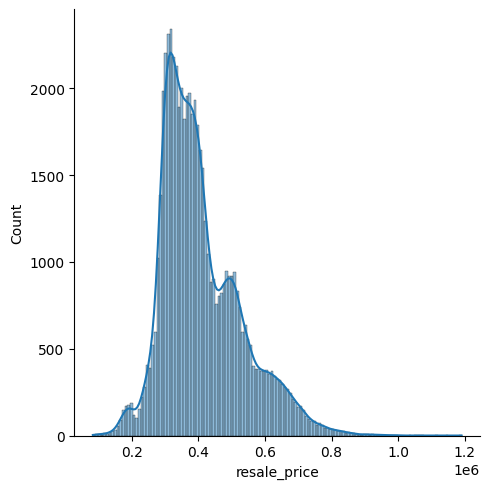

Skew: 0.9538173072776903
Kurtosis: 0.9929617560950645


In [13]:
sns.displot(df_94['resale_price'], kde=True)
plt.show()
print(f"Skew: {df_94['resale_price'].skew()}")
print(f"Kurtosis: {df_94['resale_price'].kurtosis()}")

sns.displot(df_95['resale_price'], kde=True)
plt.show()
print(f"Skew: {df_95['resale_price'].skew()}")
print(f"Kurtosis: {df_95['resale_price'].kurtosis()}")

# LinearRegression()

In [85]:
import importlib
from src import model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

importlib.reload(model)

<module 'src.model' from 'c:\\Users\\hurry\\Documents\\Github\\HDB_Resale_Price\\src\\model.py'>

## Build individual models by flat_type


1 ROOM
Before filtering: 1291
After filtering: 1291
Chosen features: ['floor_area_sqm', 'remaining_lease', 'storey', 'town', 'flat_model']
5
5
(1032, 6)
Training model: RandomForestRegressor(max_depth=8, verbose=1)
Train score: 0.94
Test score: 0.94
train_model executed in 0.18 seconds 

R2: 0.94
MSE: 91,943,401.31
RMSE: 9,588.71


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


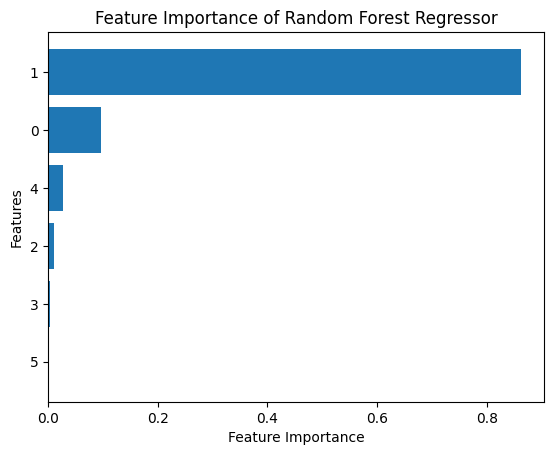

evaluate_model executed in 0.09 seconds 

2 ROOM
Before filtering: 11531
After filtering: 9645
Chosen features: ['floor_area_sqm', 'remaining_lease', 'storey', 'town', 'flat_model']
5
5
(7716, 30)
Training model: RandomForestRegressor(max_depth=8, verbose=1)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Train score: 0.86
Test score: 0.84
train_model executed in 3.06 seconds 

R2: 0.84
MSE: 284,562,461.09
RMSE: 16,868.98


IndexError: index 11 is out of bounds for axis 0 with size 1

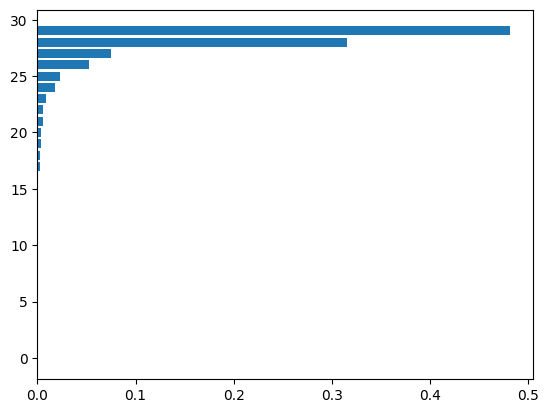

In [86]:
for flat_type in df['flat_type'].unique():
    print(flat_type)
    flat_type_df = df[df['flat_type'] == flat_type]
    print(f"Before filtering: {len(flat_type_df)}")
    df_filtered = flat_type_df.groupby(['flat_model', 'town', 'street_name', 'block'], observed=True).filter(lambda x: len(x) >= 20)
    print(f"After filtering: {len(df_filtered)}")
    chosen_features = ['floor_area_sqm', 'remaining_lease', 'storey',
                    'town',
                    'flat_model',
                    # 'street_name'
                    # 'log_floor_area_sqm', 'log_remaining_lease', 'log_storey',
                    # 'squared_floor_area_sqm', 'squared_remaining_lease', 'squared_storey'
    ]

    y_test, y_pred, rfmodel, X_train = model.train_model(df_filtered, 'resale_price', chosen_features, RandomForestRegressor(max_depth=8, verbose=1), preprocess=True)
    model.evaluate_model(y_test, y_pred, rfmodel, X_train, 'tree')


## Linearity

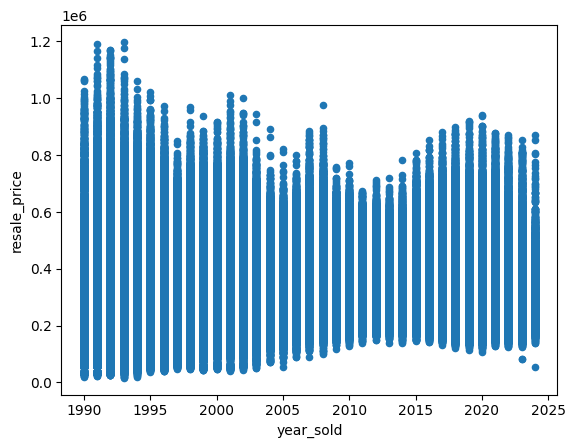

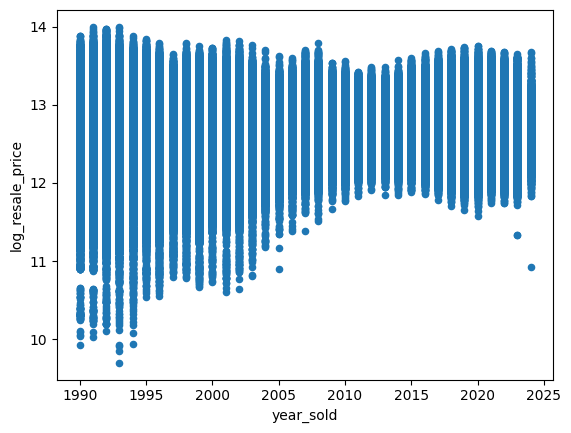

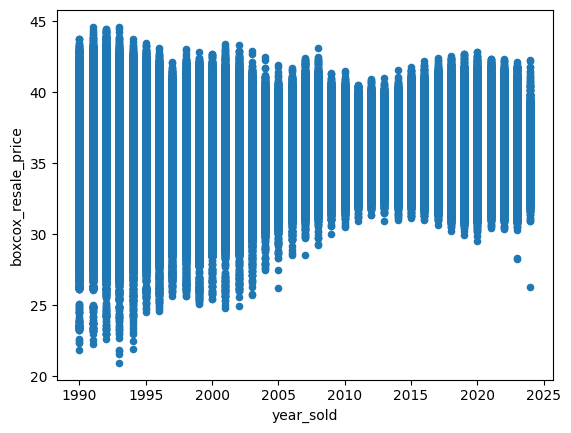

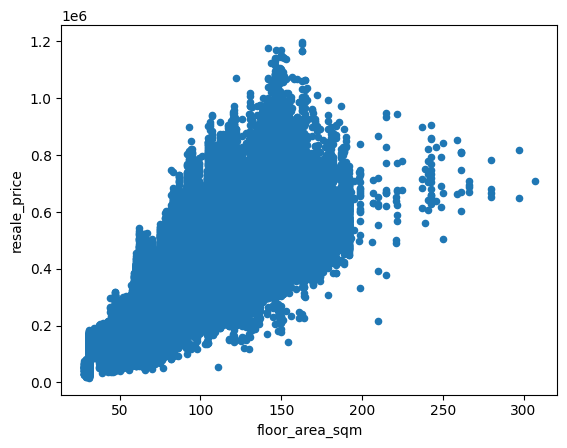

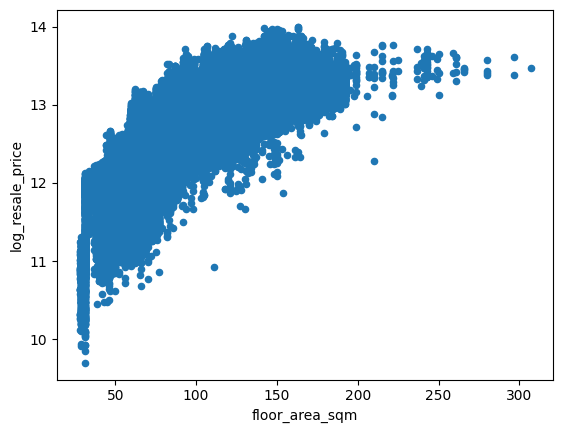

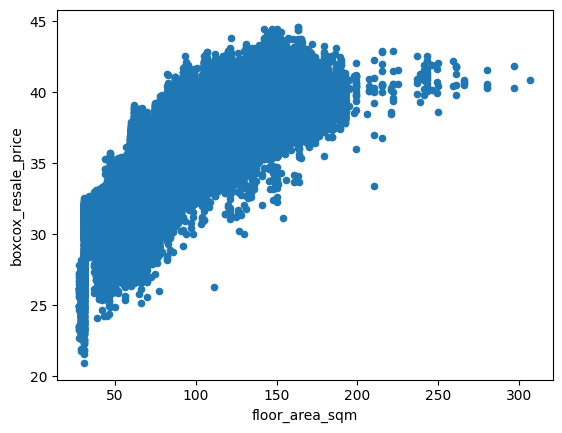

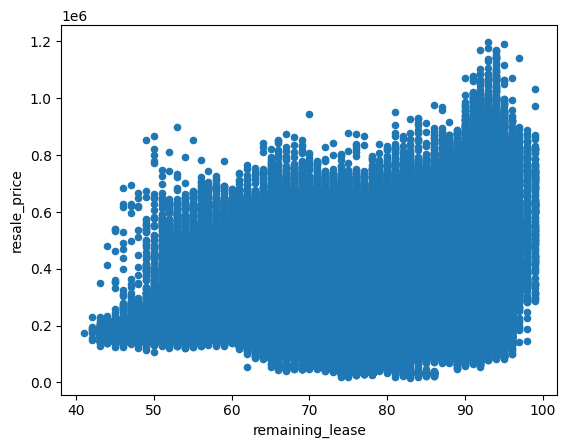

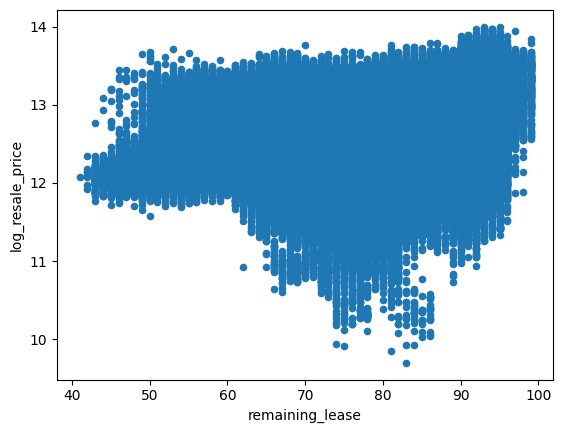

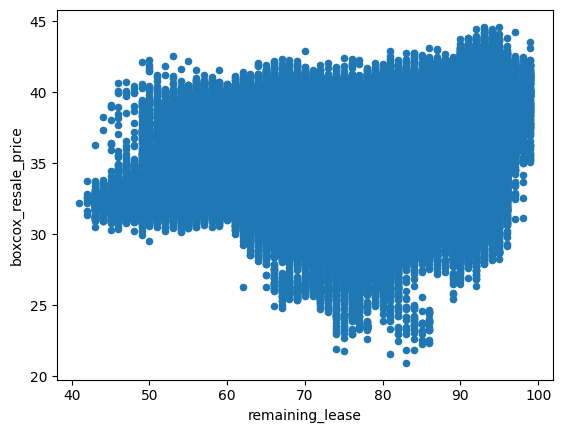

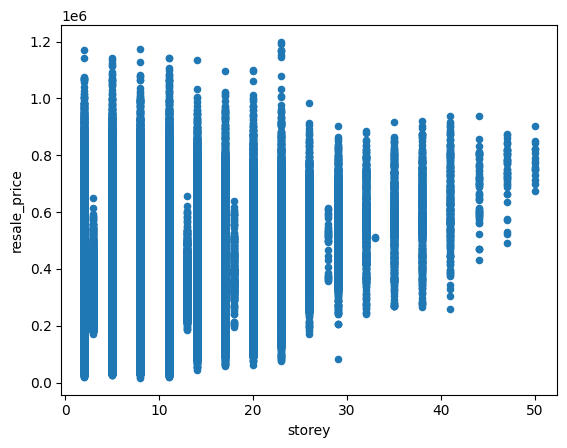

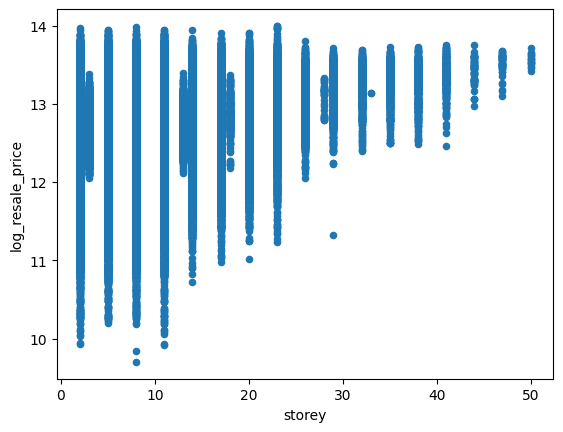

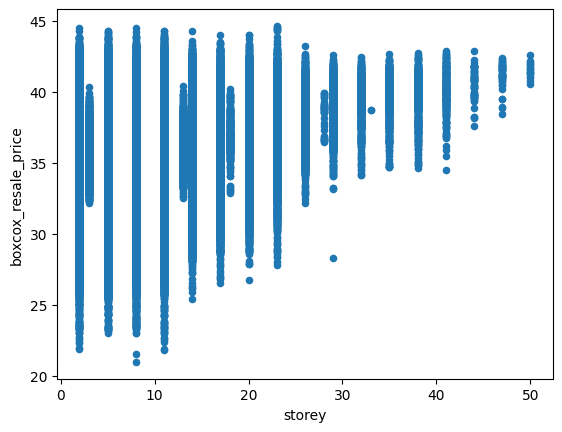

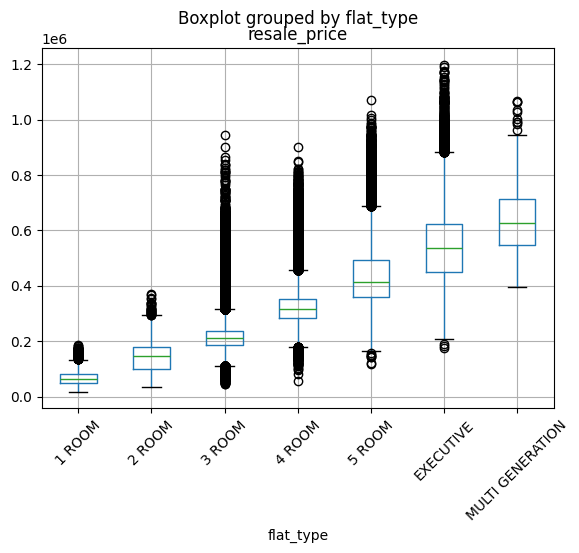

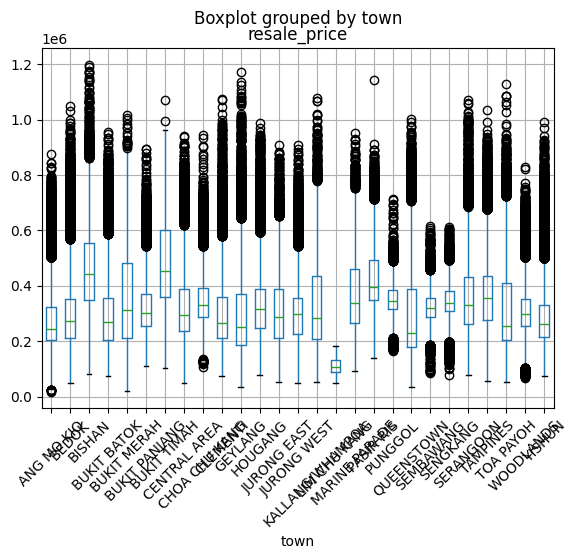

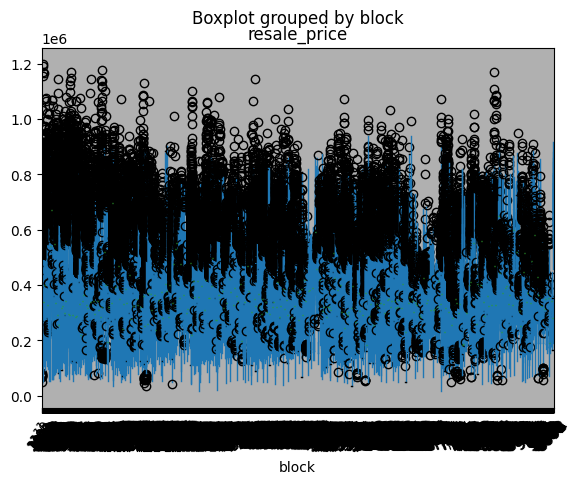

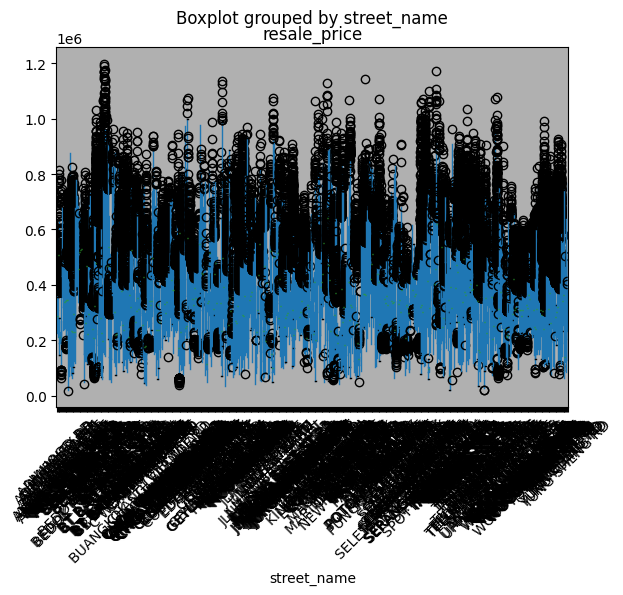

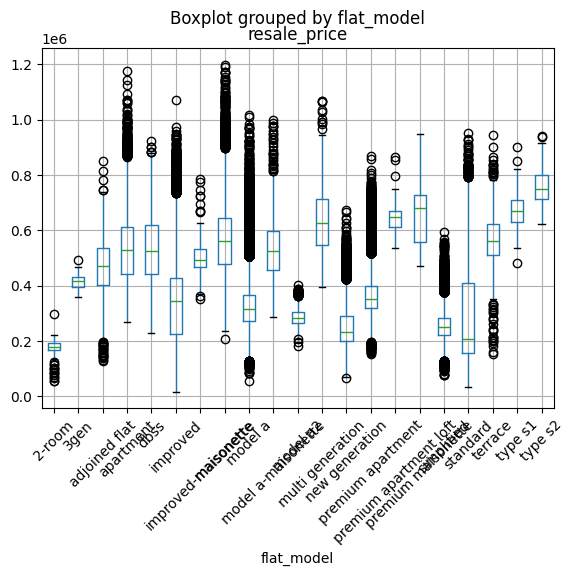

In [10]:
# Check for linearity of factors
y_variable = 'resale_price'
y_log_variable = 'log_resale_price'
y_boxcox_variable = 'boxcox_resale_price'
y_variables = [y_variable, y_log_variable, y_boxcox_variable]

def scatter_plot(df, x_variable, y_variable):
    if x_variable not in y_variables:
        df.plot.scatter(x=x_variable, y=y_variable)

def boxplot_sorted(df, categorical_variable, y_variable):
    sorted_idx = df.groupby(categorical_variable)[y_variable].median().sort_values().index
    sorted_df = df.set_index(categorical_variable).loc[sorted_idx].reset_index()
    sorted_df.boxplot(column=y_variable, by=categorical_variable)
    plt.xticks(rotation=45)

# Scatter plot
numerical_variables = df.select_dtypes(include=['number']).columns
scatter_plots = [(x_var, y_var) for x_var in numerical_variables for y_var in y_variables if x_var != y_var]
for x_var, y_var in scatter_plots:
    scatter_plot(df, x_var, y_var)

# Boxplot
categorical_variables = df.select_dtypes(include=['object']).columns
for categorical_variable in categorical_variables:
    if categorical_variable != y_variable:
        boxplot_sorted(df, categorical_variable, y_variable)


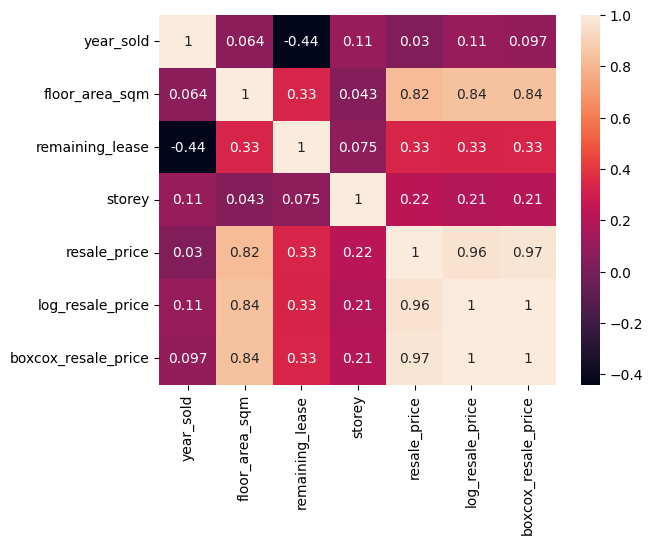

,variable,VIF
0,const,61.78
1,remaining_lease,1.13
2,floor_area_sqm,1.13
3,storey,1.01


In [ ]:
# check for multicollinearity
correlation_matrix = df.select_dtypes(include='number').corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# The Variance Inflation Factor (VIF) is a metric that measures how much the variance of an estimated regression coefficient increases due to multicollinearity in a multiple regression model.
# How it works:
# Single Factor Regression: Consider regressing one of your independent variables against all other independent variables in your model.
# R-squared Value:  Get the R-squared value from this regression.
# Calculation: The VIF for that independent variable is calculated as: VIF = 1 / (1 - R-squared)
# Ideal Value: A VIF of 1 indicates no correlation between a given independent variable and the other predictors.
# Caution: VIF values of 5 or above suggest potential multicollinearity issues.
# Severe: A VIF of 10 or higher is generally considered a serious cause for concern.
X = add_constant(df[['remaining_lease', 'floor_area_sqm', 'storey']].select_dtypes(include='number'))
vif = pd.DataFrame()
vif['variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values('VIF', ascending=False)
vif['VIF'] = vif['VIF'].apply(lambda x: '{:.2f}'.format(x))
vif

In [9]:
from sklearn.ensemble import RandomForestRegressor

chosen_features = ['floor_area_sqm', 'remaining_lease', 'storey',
                   'flat_type',
                   'town',
                  #  'flat_model',
]

y_test, y_pred = model.train_model(df, 'resale_price', chosen_features, RandomForestRegressor(verbose=2))
model.evaluate_model(y_test, y_pred)

Chosen features: ['floor_area_sqm', 'remaining_lease', 'storey', 'flat_type', 'town']
Training model: RandomForestRegressor(verbose=2)
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100


Chosen features: ['floor_area_sqm', 'remaining_lease', 'storey', 'flat_type', 'town']
Training model: LinearRegression()
Test score: 0.82
fit_model executed in 0.93 seconds 

train_model executed in 2.15 seconds 

R2: 0.82
MSE: 2,903,868,250.75
RMSE: 53,887.55


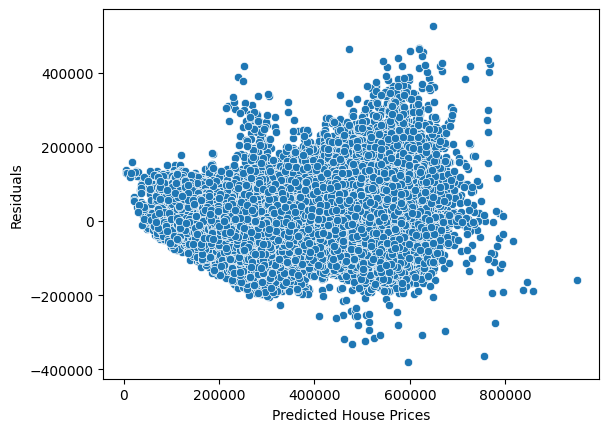

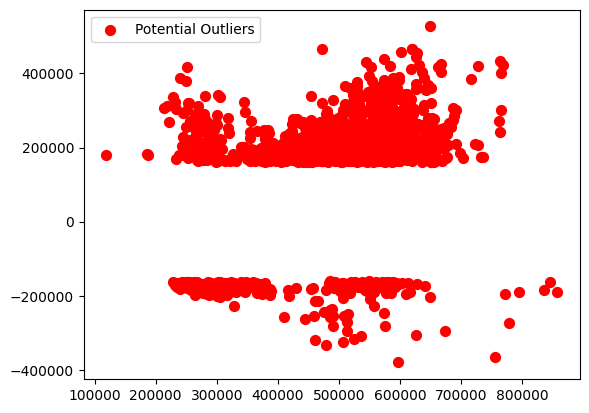

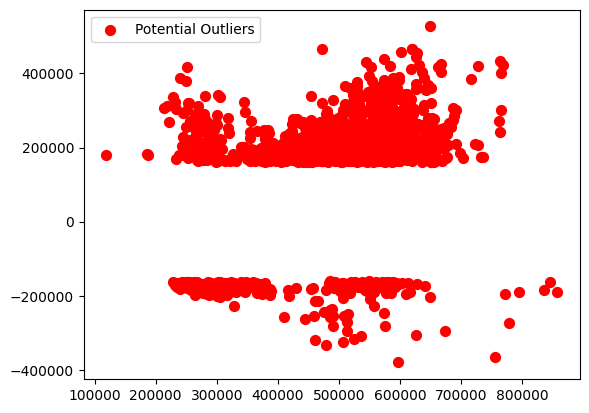

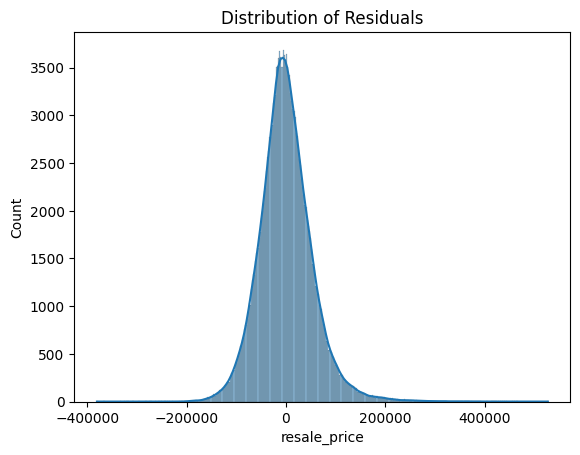

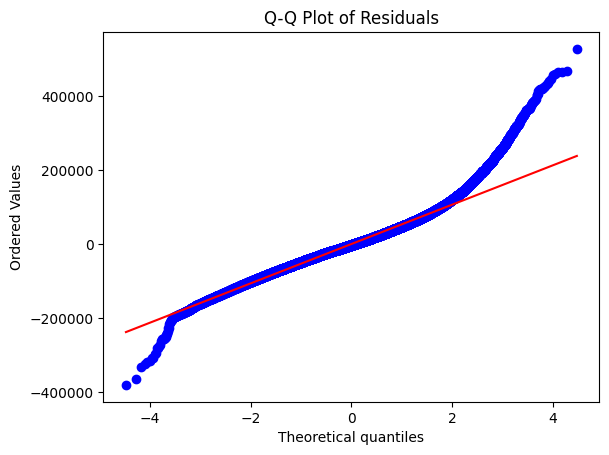

evaluate_model executed in 3.03 seconds 

Chosen features: ['floor_area_sqm', 'remaining_lease', 'storey', 'flat_type', 'town']
Training model: LinearRegression()
Test score: 0.83
fit_model executed in 0.97 seconds 

train_model executed in 2.14 seconds 

R2: 0.83
MSE: 2,675,359,794.96
RMSE: 51,723.88


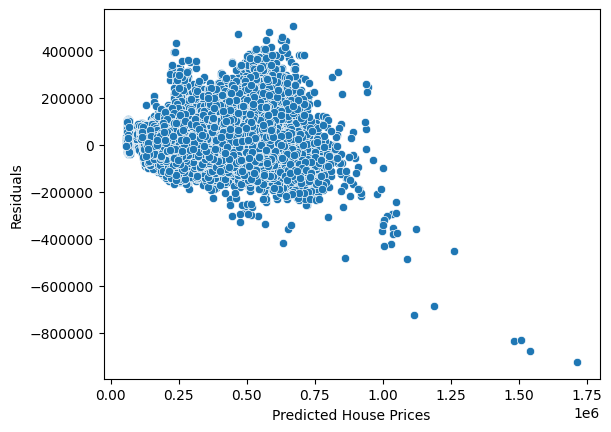

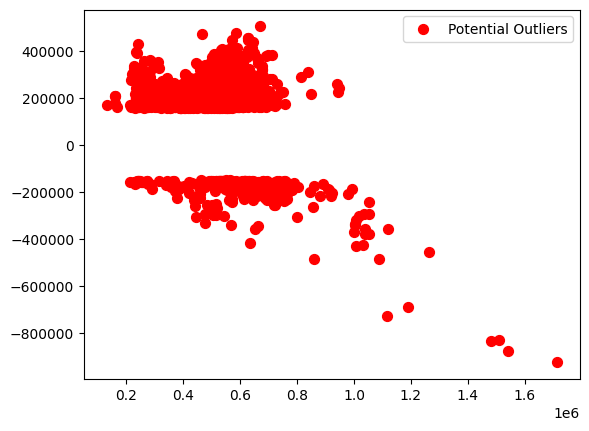

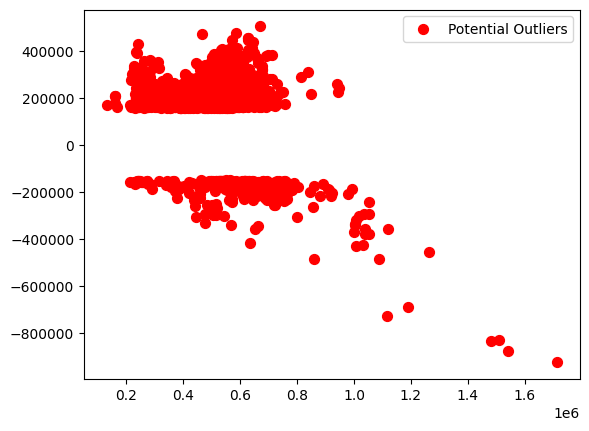

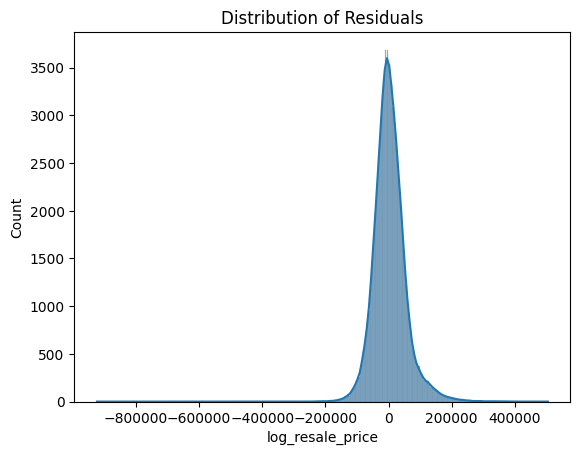

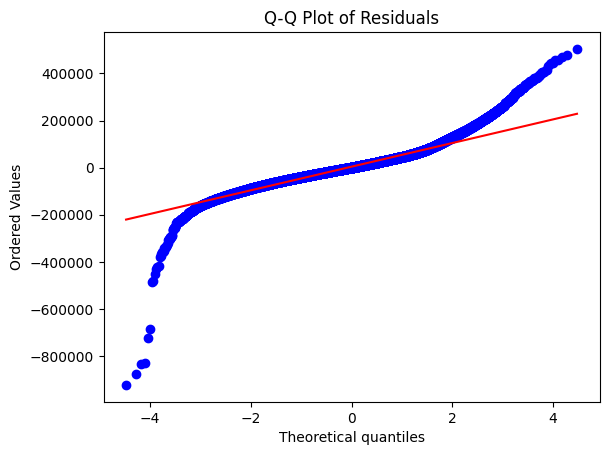

evaluate_model executed in 2.97 seconds 

Chosen features: ['floor_area_sqm', 'remaining_lease', 'storey', 'flat_type', 'town']
Training model: LinearRegression()
Test score: 0.83
fit_model executed in 0.91 seconds 

train_model executed in 2.01 seconds 

R2: 0.84
MSE: 2,647,498,704.42
RMSE: 51,453.85


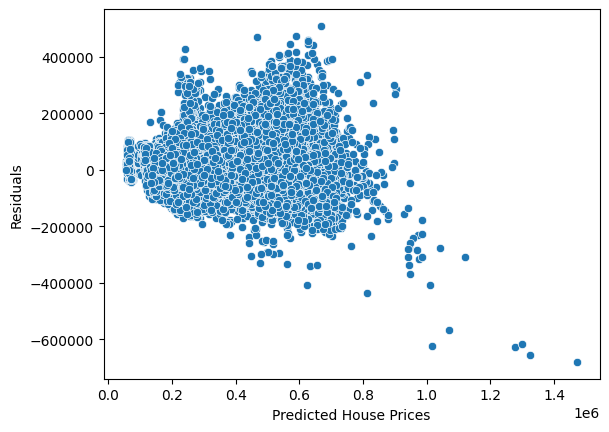

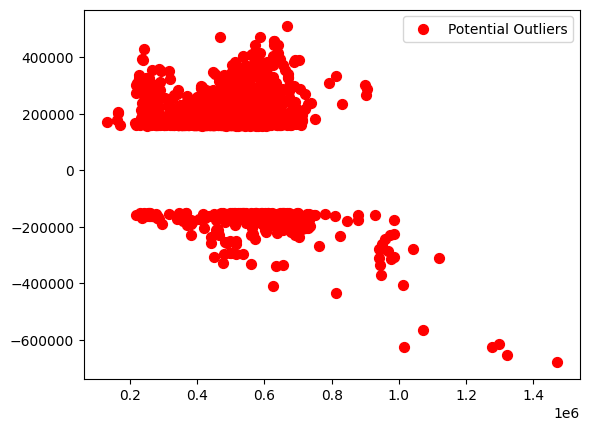

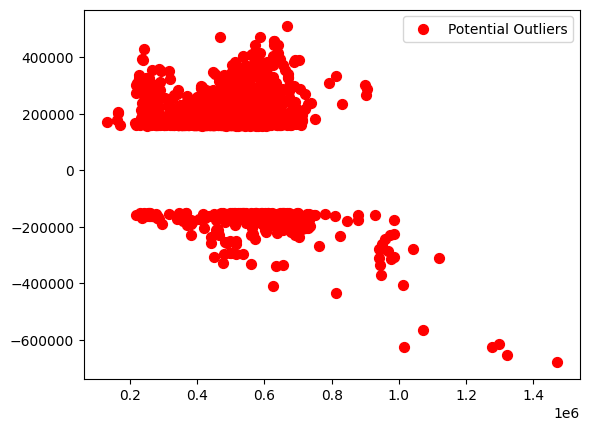

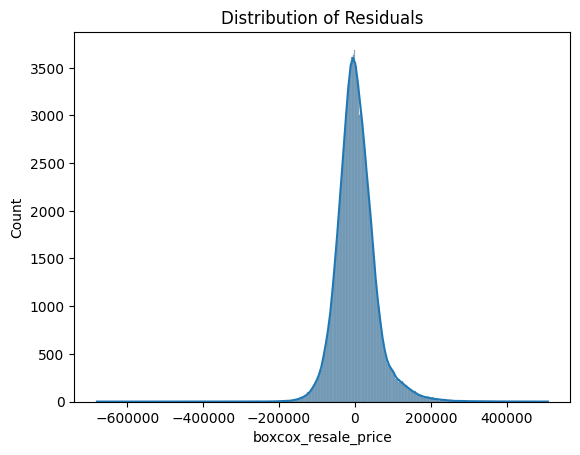

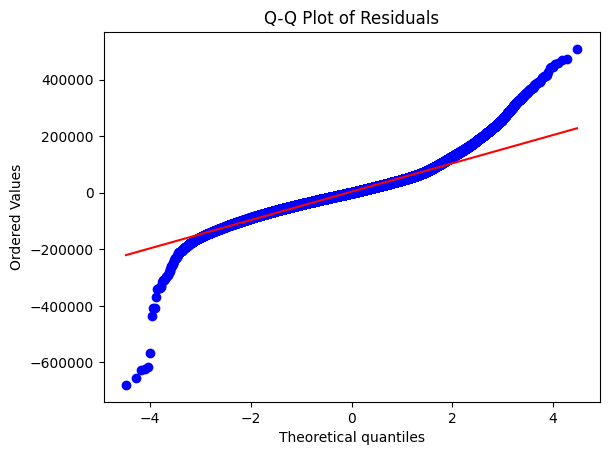

evaluate_model executed in 2.93 seconds 



In [12]:
from sklearn.linear_model import LinearRegression

# Simple Linear Regression
chosen_features = ['floor_area_sqm', 'remaining_lease', 'storey',
                   'flat_type',
                   'town',
                  #  'flat_model',
]

# Using normal resale price
y_test, y_pred = model.train_model(df, 'resale_price', chosen_features, LinearRegression())
model.evaluate_model(y_test, y_pred)

# Using log transformed resale price
y_test, y_pred = model.train_model(df, 'log_resale_price', chosen_features, LinearRegression())
y_test = np.exp(y_test)
y_pred = np.exp(y_pred)
model.evaluate_model(y_test, y_pred)

# Using boxcox transformed resale price
y_test, y_pred = model.train_model(df, 'boxcox_resale_price', chosen_features, LinearRegression())
y_test = inv_boxcox(y_test, lmbda)
y_pred = inv_boxcox(y_pred, lmbda)
model.evaluate_model(y_test, y_pred)

## Independence of Residuals

## Normality of residuals

## Equal variance (Homescedascity)